In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

# Dataset kök klasörünü listele
!ls /kaggle/input/cat-and-dog


test_set  training_set


In [4]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true" 

from absl import logging
logging.set_verbosity(logging.ERROR)

import os, random
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# Tekrarlanabilirlik
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)


TensorFlow: 2.18.0
GPU: []


In [5]:

base_dir = Path("/kaggle/input/cat-and-dog")

train_root = base_dir / "training_set" / "training_set"
test_root  = base_dir / "test_set" / "test_set"

print("Train root:", train_root)
print("Test  root:", test_root)
print("Train exists:", train_root.exists(), "| Test exists:", test_root.exists())

# Hiperparametreler
IMG_SIZE   = 224
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE


Train root: /kaggle/input/cat-and-dog/training_set/training_set
Test  root: /kaggle/input/cat-and-dog/test_set/test_set
Train exists: True | Test exists: True


In [6]:

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")

normalization = layers.Rescaling(1./255)

# Train/Val/Test tf.data pipeline
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    validation_split=0.10,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    validation_split=0.10,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_root,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
print("Classes:", class_names)


train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 8005 files belonging to 2 classes.
Using 7205 files for training.
Found 8005 files belonging to 2 classes.
Using 800 files for validation.
Found 2023 files belonging to 2 classes.
Classes: ['cats', 'dogs']


Epoch 1/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5187 - loss: 0.6923
Epoch 1: val_accuracy improved from -inf to 0.51375, saving model to /kaggle/working/cvd_baseline.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.5187 - loss: 0.6923 - val_accuracy: 0.5138 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 2/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5556 - loss: 0.6756
Epoch 2: val_accuracy improved from 0.51375 to 0.54125, saving model to /kaggle/working/cvd_baseline.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.5556 - loss: 0.6756 - val_accuracy: 0.5412 - val_loss: 0.6755 - learning_rate: 0.0010
Epoch 3/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5945 - loss: 0.6608
Epoch 3: val_accuracy improved from 0.54125 to 0.61875, saving model to /kaggle/working/cvd_baseline.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.5945 - loss: 0.6608 - val_accuracy: 0.6187 - val_loss: 0.6494 - learning_rate: 0.0010
Epoc

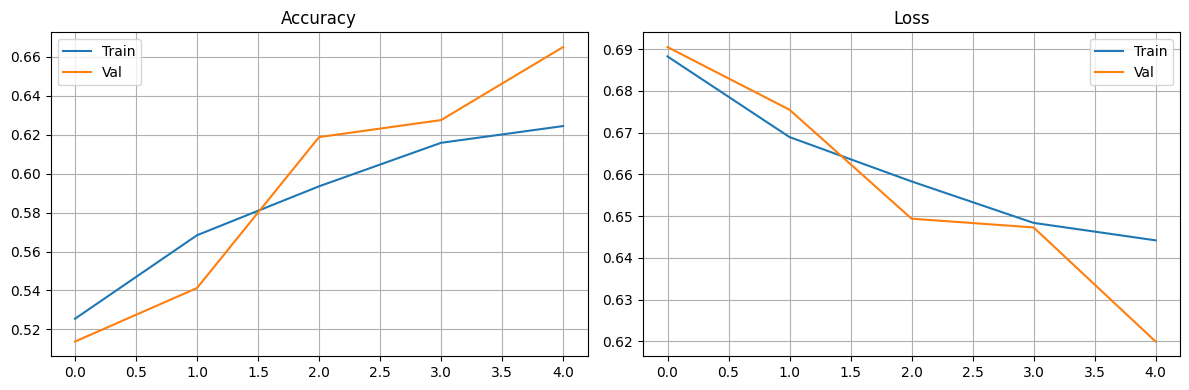

In [7]:
def build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout=0.3):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = normalization(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # binary
    return keras.Model(inputs, outputs, name="baseline_cnn")

baseline = build_baseline_cnn()
baseline.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_BASE = 5  
ckpt_base = "/kaggle/working/cvd_baseline.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_base, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

hist_base = baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_BASE,
    callbacks=callbacks,
    verbose=1
)


plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(hist_base.history["accuracy"], label="Train"); plt.plot(hist_base.history["val_accuracy"], label="Val"); plt.title("Accuracy"); plt.legend(); plt.grid(True)
plt.subplot(1,2,2); plt.plot(hist_base.history["loss"], label="Train"); plt.plot(hist_base.history["val_loss"], label="Val"); plt.title("Loss"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()




151111111111110

[Baseline] Test Accuracy: 0.6614 | Test Loss: 0.6176

Classification report:
               precision    recall  f1-score   support

        cats     0.6258    0.8022    0.7031      1011
        dogs     0.7249    0.5208    0.6061      1012

    accuracy                         0.6614      2023
   macro avg     0.6753    0.6615    0.6546      2023
weighted avg     0.6754    0.6614    0.6546      2023

Confusion Matrix:
 [[811 200]
 [485 527]]


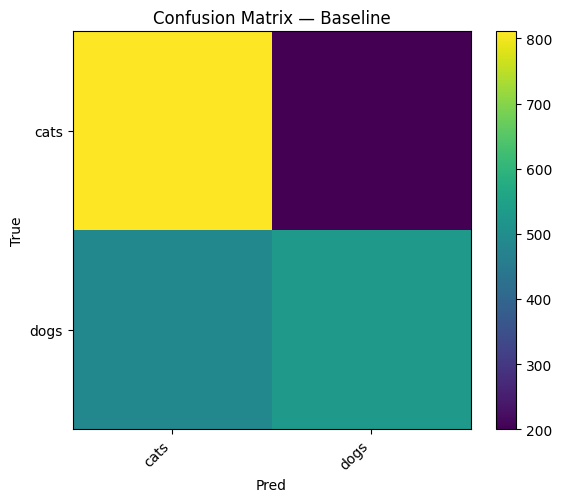

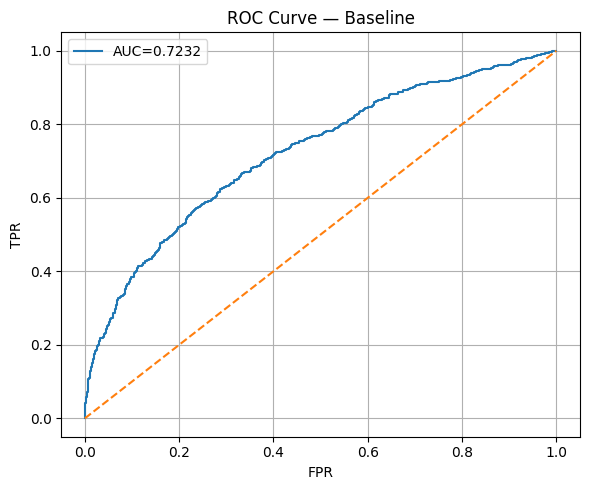

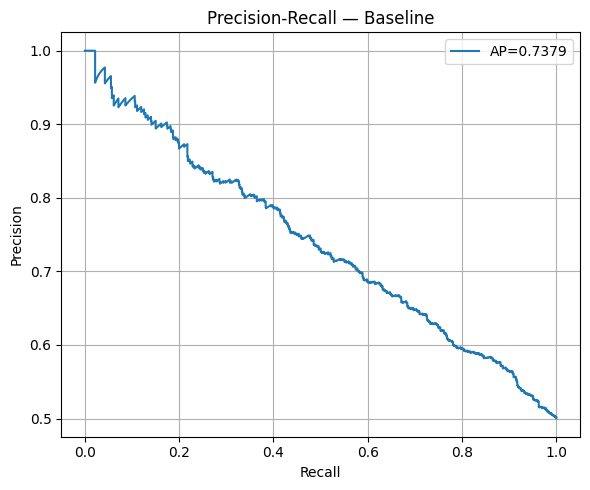

Macro F1: 0.6546


In [8]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

test_loss, test_acc = baseline.evaluate(test_ds, verbose=0)
print(f"[Baseline] Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

y_true, y_prob = [], []
for images, labels in test_ds:
    probs = baseline.predict(images, verbose=0).squeeze()
    y_prob.extend(probs.tolist())
    y_true.extend(labels.numpy().tolist())
y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)


print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — Baseline")
plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha='right')
plt.yticks(ticks, class_names)
plt.ylabel("True"); plt.xlabel("Pred")
plt.tight_layout(); plt.show()

auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve — Baseline"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

ap = average_precision_score(y_true, y_prob)
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP={ap:.4f}")
plt.title("Precision-Recall — Baseline"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

print("Macro F1:", round(f1_score(y_true, y_pred, average="macro"), 4))


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

def build_mobilenet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout=0.2):
    base = keras.applications.MobileNetV2(
        input_shape=input_shape, include_top=False, weights="imagenet"
    )
    base.trainable = False  

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # binary
    model = keras.Model(inputs, outputs, name="mobilenetv2_transfer")
    return model, base

transfer, base = build_mobilenet_model()
transfer.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
transfer.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/3
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9098 - loss: 0.2213
Epoch 1: val_accuracy improved from -inf to 0.98375, saving model to /kaggle/working/cvd_mobilenetv2_top.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.9100 - loss: 0.2209 - val_accuracy: 0.9837 - val_loss: 0.0413
Epoch 2/3
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9750 - loss: 0.0645
Epoch 2: val_accuracy improved from 0.98375 to 0.99125, saving model to /kaggle/working/cvd_mobilenetv2_top.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.9750 - loss: 0.0644 - val_accuracy: 0.9912 - val_loss: 0.0350
Epoch 3/3
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9794 - loss: 0.0547
Epoch 3: val_accuracy improved from 0.99125 to 0.99250, saving model to /kaggle/working/cvd_mobilenetv2_top.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9794 - loss: 0.0546 - val_accuracy: 0.9925 - val_loss: 0.0264


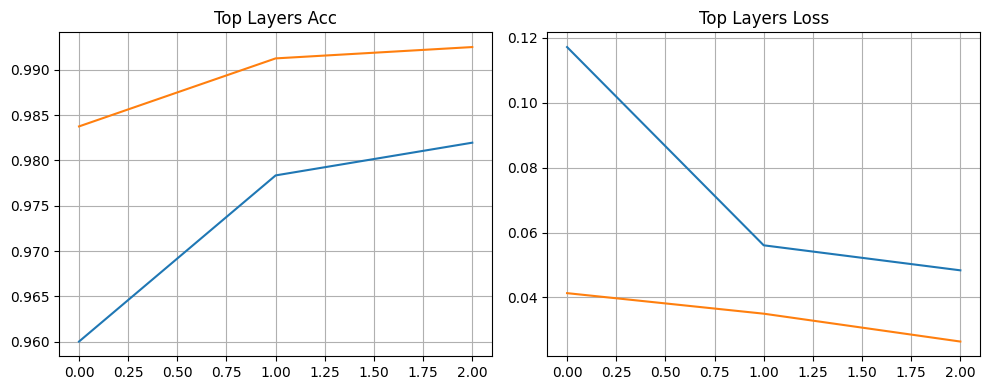

In [10]:
EPOCHS_TOP = 3
ckpt_top = "/kaggle/working/cvd_mobilenetv2_top.keras"

callbacks_top = [
    keras.callbacks.ModelCheckpoint(ckpt_top, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
]

hist_top = transfer.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_TOP, callbacks=callbacks_top, verbose=1
)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist_top.history["accuracy"]); plt.plot(hist_top.history["val_accuracy"]); plt.title("Top Layers Acc"); plt.grid(True)
plt.subplot(1,2,2); plt.plot(hist_top.history["loss"]); plt.plot(hist_top.history["val_loss"]); plt.title("Top Layers Loss"); plt.grid(True)
plt.tight_layout(); plt.show()


Epoch 1/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8798 - loss: 0.3009
Epoch 1: val_accuracy improved from -inf to 0.98625, saving model to /kaggle/working/cvd_mobilenetv2_finetuned.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.8800 - loss: 0.3003 - val_accuracy: 0.9862 - val_loss: 0.0512 - learning_rate: 1.0000e-05
Epoch 2/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9605 - loss: 0.0992
Epoch 2: val_accuracy improved from 0.98625 to 0.98875, saving model to /kaggle/working/cvd_mobilenetv2_finetuned.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9605 - loss: 0.0992 - val_accuracy: 0.9887 - val_loss: 0.0326 - learning_rate: 1.0000e-05
Epoch 3/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9701 - loss: 0.0745
Epoch 3: val_accuracy improved from 0.98875 to 0.99000, saving model to /kaggle/working/cvd_mobilenetv2_finetuned.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.9701 - loss: 0.0745 - val_accuracy: 0.9900 

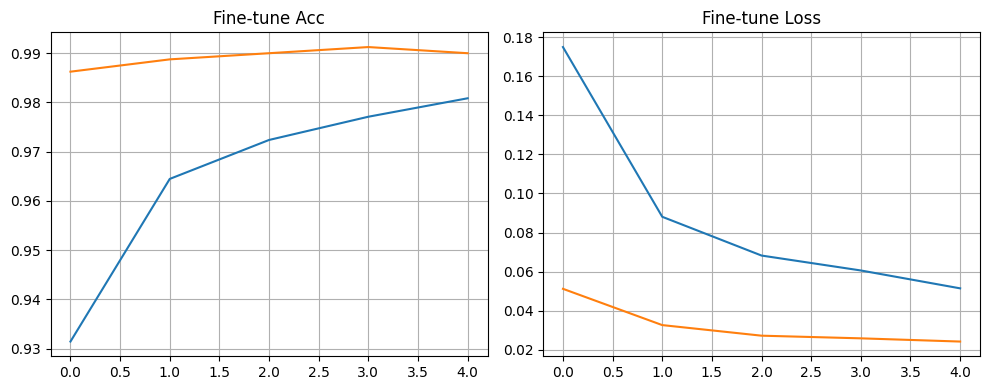

In [11]:

for i, layer in enumerate(base.layers):
    layer.trainable = (i >= int(len(base.layers) * 0.7))

transfer.compile(
    optimizer=keras.optimizers.Adam(1e-5), 
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_FT = 5
ckpt_ft = "/kaggle/working/cvd_mobilenetv2_finetuned.keras"
callbacks_ft = [
    keras.callbacks.ModelCheckpoint(ckpt_ft, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1),
]

hist_ft = transfer.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_FT, callbacks=callbacks_ft, verbose=1
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist_ft.history["accuracy"]); plt.plot(hist_ft.history["val_accuracy"]); plt.title("Fine-tune Acc"); plt.grid(True)
plt.subplot(1,2,2); plt.plot(hist_ft.history["loss"]); plt.plot(hist_ft.history["val_loss"]); plt.title("Fine-tune Loss"); plt.grid(True)
plt.tight_layout(); plt.show()


[Transfer] Test Accuracy: 0.9906 | Test Loss: 0.0318

Classification report:
               precision    recall  f1-score   support

        cats     0.9960    0.9852    0.9906      1011
        dogs     0.9853    0.9960    0.9907      1012

    accuracy                         0.9906      2023
   macro avg     0.9907    0.9906    0.9906      2023
weighted avg     0.9907    0.9906    0.9906      2023



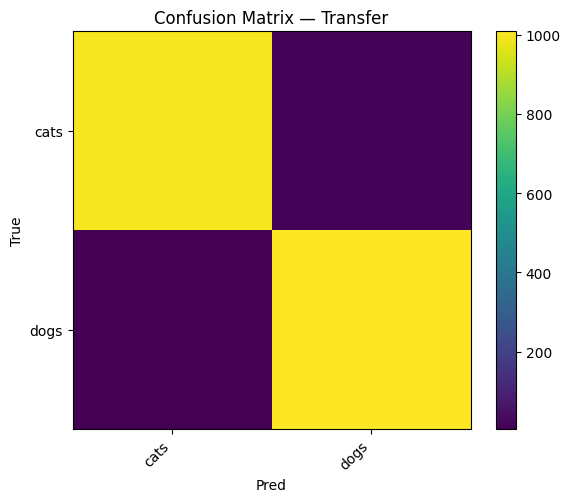

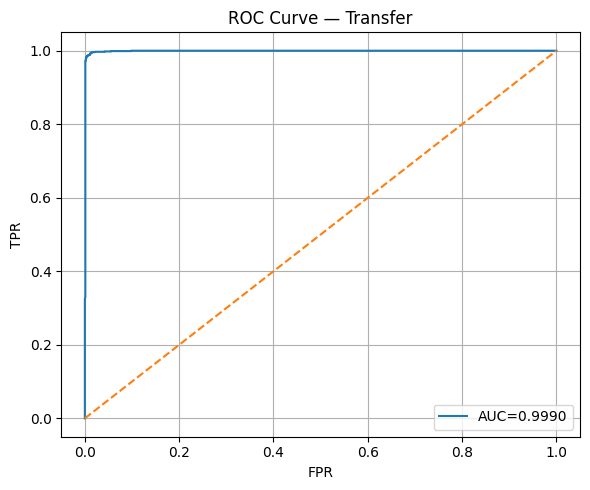

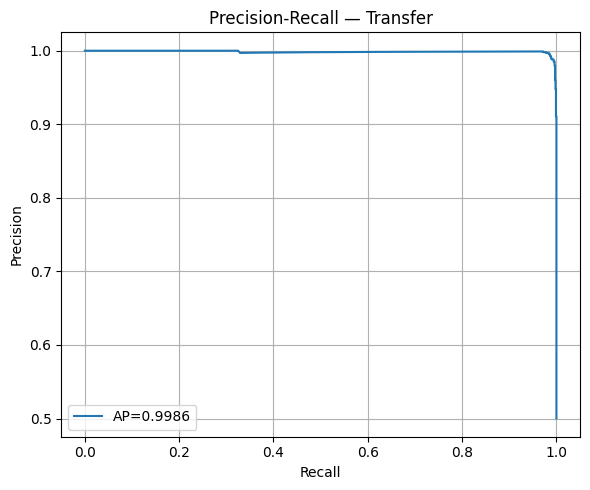

Macro F1: 0.9906
Saved model to: /kaggle/working/cats_vs_dogs_transfer.keras


In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


loss_t, acc_t = transfer.evaluate(test_ds, verbose=0)
print(f"[Transfer] Test Accuracy: {acc_t:.4f} | Test Loss: {loss_t:.4f}")


y_true, y_prob = [], []
for images, labels in test_ds:
    probs = transfer.predict(images, verbose=0).squeeze()
    y_prob.extend(probs.tolist()); y_true.extend(labels.numpy().tolist())
y_true = np.array(y_true); y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation='nearest'); plt.title("Confusion Matrix — Transfer")
plt.colorbar(); ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha='right'); plt.yticks(ticks, class_names)
plt.ylabel("True"); plt.xlabel("Pred"); plt.tight_layout(); plt.show()

auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label=f"AUC={auc:.4f}"); plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve — Transfer"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

ap = average_precision_score(y_true, y_prob)
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(6,5)); plt.plot(rec, prec, label=f"AP={ap:.4f}")
plt.title("Precision-Recall — Transfer"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

print("Macro F1:", round(f1_score(y_true, y_pred, average="macro"), 4))


SAVE_PATH = "/kaggle/working/cats_vs_dogs_transfer.keras"
transfer.save(SAVE_PATH)
print("Saved model to:", SAVE_PATH)
